# Developing the Capacity Model

## Overview 

This notebook contains the code to develop the capacity model. 

Initially 3 different models are compared (Linear regression, Random Forest regresstion, Gradient Boosted regression).

Hyper-parameters of the best model are fine-tunes to maximise performance in unseen data while preventing over-fitting and minimising model complexity

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('../data/master_scaled.csv', index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) 
               if '/' in c else c for c in dta.columns]

In [5]:
dta.head()

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives,year
0,00Q,Jan,406.655830,308.945095,310.561801,234.716187,4568.019766,1179.855246,14.8942,97.2,99.7,94.4,2018
1,00Q,Feb,349.933603,256.872981,261.756435,205.298797,3910.918344,1075.452189,14.8942,97.2,99.7,94.4,2018
2,00Q,Mar,413.247659,300.690725,303.676215,234.716187,4051.778545,1210.874032,14.8942,97.2,99.7,94.4,2018
3,00Q,Apr,349.608595,278.140171,264.973181,203.677924,3974.433001,1186.166427,14.8942,97.2,99.7,94.4,2018
4,00Q,May,361.100544,284.419492,294.361403,227.926437,4232.385761,1299.297713,14.8942,97.2,99.7,94.4,2018


In [6]:
dta.shape

(1465, 13)

### Add random feature

In [7]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [8]:
dta.shape

(1465, 14)

## Model Comparison

Features in the dataset that measure service capacity are:

- *gp_appt_available*: the number of GP appointments available per 10,000 people per month
- *111_111_offered*: the number of 111 calls offered (i.e. that the service can answer) per 10,000 people per month
- *amb_sys_answered*: the number of calls answered by the ambulance system per 10,000 people per month

### Pair plot 

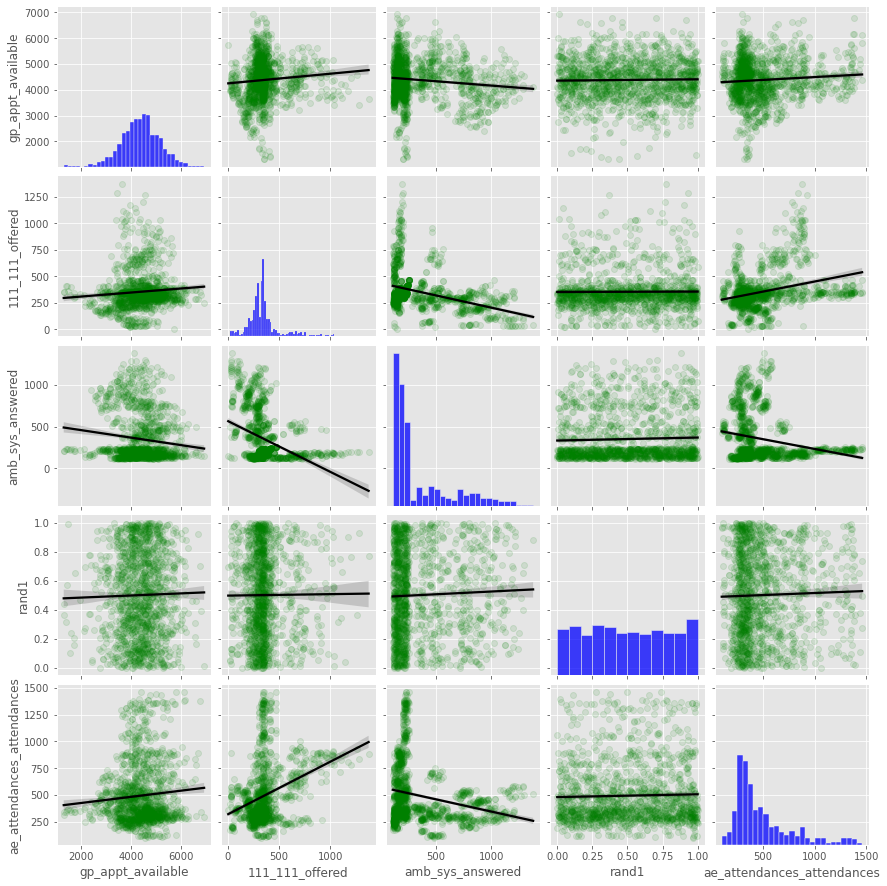

In [9]:
fig = sns.pairplot(dta[['gp_appt_available',
                        '111_111_offered', 'amb_sys_answered', 'rand1',
                        'ae_attendances_attendances']]\
                   .select_dtypes(include=np.number), 
                   kind="reg",
                   plot_kws={'line_kws':{'color':'black'}, 
                            'scatter_kws': 
                             {'color':'green','alpha': 0.1}},
                   diag_kws={'color':'blue'})

#plt.savefig('capacity_pair.png')

### Linear regression 

In [10]:
model = LinearRegression()

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.coef_)

#### Performance 

In [11]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [12]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.112154,0.103536
std,0.004969,0.021133
min,0.099014,0.058157
25%,0.109664,0.090542
50%,0.111917,0.104774
75%,0.116497,0.115632
max,0.120133,0.153024


#### Feature Importance 

In [13]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.014966,0.406464,-0.131382,28.739829
std,0.003882,0.013064,0.008782,8.084947
min,0.004158,0.383218,-0.147640,13.371285
25%,0.012594,0.396540,-0.139265,22.160666
50%,0.015539,0.405323,-0.130168,28.150991
75%,0.017175,0.417263,-0.124203,34.959225
max,0.023572,0.427253,-0.116682,45.398180


### Random forest 

In [14]:
model = RandomForestRegressor(max_depth=5, n_estimators=5,
                              random_state=0)
#model = GradientBoostingRegressor(max_depth=5, n_estimators=5)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.feature_importances_)

#### Performance 

In [15]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [16]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.479277,0.401029
std,0.020058,0.038700
min,0.443567,0.295927
25%,0.469637,0.383242
50%,0.480219,0.404819
75%,0.489874,0.425390
max,0.512786,0.464532


#### Feature importance 

In [17]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.125053,0.311816,0.542283,0.020849
std,0.025627,0.064223,0.050866,0.010915
min,0.069244,0.215253,0.461140,0.008414
25%,0.098340,0.247569,0.498306,0.013307
50%,0.132378,0.328166,0.549028,0.017386
75%,0.145075,0.360778,0.587425,0.022617
max,0.154195,0.409216,0.620752,0.045972


### Gradient boosted tress

In [18]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=5, 
                                  random_state=1)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))
    
    feats.append(model.feature_importances_)

#### Performance 

In [19]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [20]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.307396,0.270857
std,0.018367,0.020894
min,0.280350,0.236348
25%,0.290973,0.256069
50%,0.308851,0.268818
75%,0.321498,0.284230
max,0.340458,0.314797


#### Feature Importance 

In [21]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.134039,0.304877,0.552706,0.008378
std,0.038665,0.129476,0.095129,0.006356
min,0.078219,0.160691,0.424616,0.000674
25%,0.094897,0.193772,0.451764,0.003518
50%,0.146702,0.204146,0.610216,0.007810
75%,0.172067,0.446402,0.637724,0.010664
max,0.186262,0.471376,0.664305,0.023612


### Summary 

**Linear Regression**

- Very poor performance, mean $R^2$ ~ 0.1

**Random Forest**

- Best performance with mean $R^2$ = 0.4 in test data
- Feature importance is stable: ambulance capacity is most important, followed by 111 then GP capacity. 
- The random feature has low importnace

**Gradient Boosted Trees**

- Doesn't perform as well as a Random Forest, mean $R^2$ = 0.27 in test data
- Feature importance is in agreement with the Random Forest


## Hyper parameter tuning 

The best model is the Random Forest. To ensure the model is not over fit to the training data we compare performance when the following parameters are varied:

- max_depth: the maximum size of any tree 
- n_estimators: the number of trees in the forest

### Maximum depth

In [22]:
d = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for depth in d:
    
    model = RandomForestRegressor(max_depth=depth, 
                                  n_estimators=4, random_state=0)

    y = dta['ae_attendances_attendances']

    X = dta[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index],
                                       y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index],
                                        y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

#### Plot 

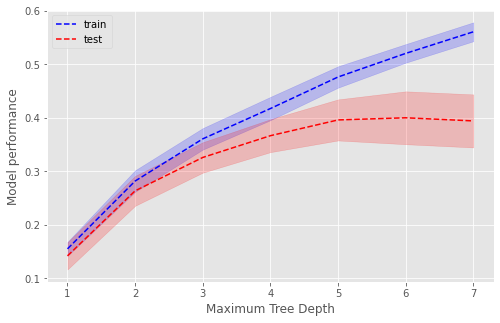

In [23]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)),
                 color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)),
                 color='r', alpha=0.2)

plt.legend(loc='best')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Model performance')
plt.show()

A depth of 5 is optimal. After this, there is no improvement in performance on unseen data (test, red dashed line) and performance continues to increase in the training data (blue dashed line) suggesting overfitting.

### Number of trees

In [24]:
n = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for est in n:
    
    model = RandomForestRegressor(max_depth=5, n_estimators=est,
                                  random_state=0)

    y = dta['ae_attendances_attendances']

    X = dta[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index],
                                       y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index],
                                        y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

#### Plot 

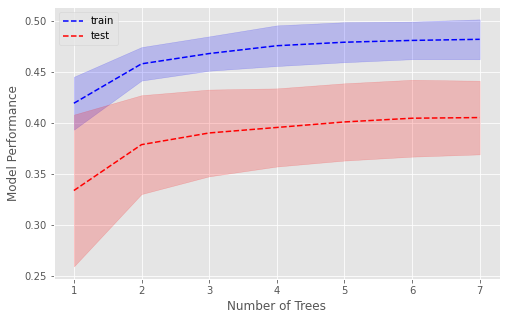

In [25]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)),
                 color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)),
                 color='r', alpha=0.2)

plt.legend(loc='best')
plt.xlabel('Number of Trees')
plt.ylabel('Model Performance')

plt.show()

The optimal number of trees is 6, beyond which there is no improvement in the training or test set.

## Final Model for paper

Fit the Random forest with optimal parameters

In [26]:
model = RandomForestRegressor(max_depth=5, n_estimators=6,
                              random_state=0)


features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.feature_importances_)

### Performance 

In [27]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [28]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.478325,0.411204
std,0.018751,0.042585
min,0.438806,0.293195
25%,0.471304,0.390506
50%,0.476277,0.409959
75%,0.492153,0.442152
max,0.515368,0.479921


### Feature Importance

In [29]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered
count,25.000000,25.000000,25.000000
mean,0.133030,0.317457,0.549513
std,0.024375,0.063230,0.047759
min,0.092214,0.215173,0.480287
25%,0.112314,0.268945,0.504005
50%,0.140140,0.323760,0.554360
75%,0.151642,0.372767,0.590018
max,0.170021,0.427284,0.629613
